In [1]:
import json 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random

import string
# import nltk
from nltk import *

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras import callbacks

In [4]:
with open("../../data/Intent.json") as train_file:
    df= json.load(train_file)

In [5]:
tags = []
inputs = []
responses = {}

for intent in df['intents']:
    responses[intent['intent']] = intent['responses']
    for lines in intent['text']:
        inputs.append(lines)
        tags.append(intent['intent'])
df = pd.DataFrame({'inputs': inputs, 'tags': tags})
df

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting
...,...,...
138,Can you prove you have a conscious,SelfAware
139,Can you prove you are self-aware please,SelfAware
140,Can you prove you are self aware please,SelfAware
141,Can you prove you have a conscious please,SelfAware


# DELETE OR ADD STOPWORDS

In [6]:
stop_words = stopwords.words("english")

In [7]:
#Add a stop word
stop_words.append("'s")
# stop_words.append("n't")

In [8]:
filtered_sentence = []

for line in inputs:
    filtered_sentence.append([w for w in word_tokenize(line) if not w.lower() in stop_words])

filtered_sentence = [' '.join(ele) for ele in filtered_sentence]

In [9]:
filtered_sentence

['Hi',
 'Hi',
 'Hola',
 'Hello',
 'Hello',
 'Hya',
 'Hya',
 'user Adam',
 'Adam',
 'Adam',
 'Adam',
 'user Bella',
 'Bella',
 'Bella',
 'Bella',
 '?',
 'Hi ?',
 'Hello ?',
 'Hola ?',
 '?',
 'Hope well ?',
 'Hello hope well ?',
 'Good thanks ! user Adam',
 'Good thanks ! Adam',
 'Good thanks ! Adam',
 'Good thanks ! Adam',
 'Great thanks ! user Bella',
 'Great thanks ! Bella',
 'Great thanks ! Bella',
 'Great thanks ! Bella',
 'name ?',
 'call ?',
 'think ?',
 'think ?',
 'talking ?',
 'name call ?',
 'Tell name',
 'name ?',
 'could call ?',
 'call ?',
 'friends call ?',
 '?',
 'Tell name ?',
 'real name ?',
 'real name please ?',
 'real name ?',
 'Tell real name ?',
 'real name ?',
 'real name please ?',
 'real name please ?',
 'time ?',
 'time ?',
 'know time ?',
 'know time ?',
 'tell time ?',
 'Tell time ?',
 'Time',
 'OK thank',
 'OK thanks',
 'OK',
 'Thanks',
 'Thank',
 'helpful',
 'talking',
 'talking',
 'talking',
 "n't",
 "n't meant",
 "n't communicating",
 "n't speaking",
 'un

In [10]:
df_sw = pd.DataFrame({'inputs': filtered_sentence, 'tags': tags})
df_sw

,inputs,tags
0,Hi,Greeting
1,Hi,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello,Greeting
...,...,...
138,prove conscious,SelfAware
139,prove self-aware please,SelfAware
140,prove self aware please,SelfAware
141,prove conscious please,SelfAware


In [11]:
#Remove duplicates
df_sw.drop_duplicates(inplace=True)

# Tokenization

In [12]:
df = df_sw.copy()

In [13]:
df["inputs"] = df["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df["inputs"] = df["inputs"].apply(lambda wrd:"".join(wrd))

In [14]:
# Tokenizer les data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df["inputs"])
train = tokenizer.texts_to_sequences(df["inputs"])

In [15]:
# Apply padding
# x_train = pad_sequences(train)
X_data = pad_sequences(train)

In [16]:
#encoding the outputs
le = LabelEncoder()
# Y_train = le.fit_transform(df['tags'])
y_data = le.fit_transform(df['tags'])

In [17]:
# input_shape = x_train.shape[1]
input_shape = X_data.shape[1]
print(input_shape)

5


In [18]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words :",vocabulary)
output_length = le.classes_.shape[0]
print("output length ", output_length)

number of unique words : 78
output length  22


In [19]:
# X_train, X_test, y_train, y_test = train_test_split(x_train, Y_train, test_size=0.3, random_state=42, stratify=Y_train)
X_train_data, X_test, y_train_data, y_test = train_test_split(X_data, y_data, test_size=0.19, random_state=42, stratify=y_data)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.24, random_state=42, stratify=y_train_data)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(69, 5)
(22, 5)
(69,)
(22,)


In [22]:
#creating model
model_sw = Sequential()
model_sw.add(Embedding(vocabulary+1,10))
model_sw.add(InputLayer(input_shape=(input_shape,)))
model_sw.add(SimpleRNN(30))
model_sw.add(Dense(output_length, activation="softmax"))

In [23]:
#compile the model
model_sw.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [24]:
# early_stopping = callbacks.EarlyStopping(
#     patience=20,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [25]:
# early_stop = callbacks.EarlyStopping(monitor="loss",mode="min",verbose=1,patience=100)

In [26]:
history = model_sw.fit(X_train,y_train, epochs=100, validation_data=(X_val, y_val))
# history = model_sw.fit(X_train,y_train, epochs=100, validation_split=0.3,callbacks=[early_stopping])

Epoch 1/100
3/3 [==============================] - 2s 207ms/step - loss: 3.0914 - accuracy: 0.0870 - val_loss: 3.0817 - val_accuracy: 0.1364
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 3.0792 - accuracy: 0.0870 - val_loss: 3.0786 - val_accuracy: 0.0909
Epoch 3/100
3/3 [==============================] - 0s 27ms/step - loss: 3.0691 - accuracy: 0.1159 - val_loss: 3.0755 - val_accuracy: 0.0909
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 3.0610 - accuracy: 0.1449 - val_loss: 3.0724 - val_accuracy: 0.0455
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 3.0526 - accuracy: 0.1449 - val_loss: 3.0696 - val_accuracy: 0.0455
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 3.0436 - accuracy: 0.1884 - val_loss: 3.0672 - val_accuracy: 0.0909
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 3.0346 - accuracy: 0.2174 - val_loss: 3.0650 - val_accuracy: 0.0909
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 21ms/step - loss: 2.2068 - accuracy: 0.6087 - val_loss: 2.6996 - val_accuracy: 0.2727
Epoch 60/100
3/3 [==============================] - 0s 20ms/step - loss: 2.1834 - accuracy: 0.5797 - val_loss: 2.6905 - val_accuracy: 0.2727
Epoch 61/100
3/3 [==============================] - 0s 18ms/step - loss: 2.1597 - accuracy: 0.5652 - val_loss: 2.6819 - val_accuracy: 0.2273
Epoch 62/100
3/3 [==============================] - 0s 19ms/step - loss: 2.1357 - accuracy: 0.5652 - val_loss: 2.6746 - val_accuracy: 0.2273
Epoch 63/100
3/3 [==============================] - 0s 20ms/step - loss: 2.1115 - accuracy: 0.5652 - val_loss: 2.6609 - val_accuracy: 0.2273
Epoch 64/100
3/3 [==============================] - 0s 20ms/step - loss: 2.0819 - accuracy: 0.5942 - val_loss: 2.6410 - val_accuracy: 0.2727
Epoch 65/100
3/3 [==============================] - 0s 18ms/step - loss: 2.0545 - accuracy: 0.6232 - val_loss: 2.6215 - val_accuracy: 0.3636
Epoch 66/100
3/3 [========

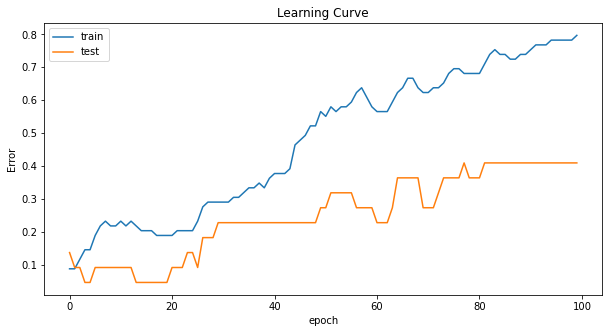

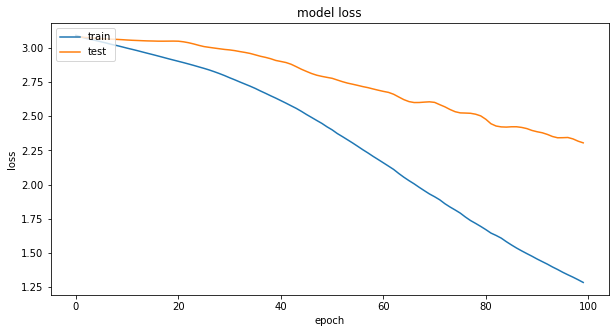

In [27]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test the chatbot

In [44]:
while True:
    texts_p = []
    prediction_input = input("You : ")
    
    #removing punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = "".join(prediction_input)
    texts_p.append(prediction_input)
    
    #tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input],input_shape)
    
    #getting output from model
    output = model_sw.predict(prediction_input)
    output = output.argmax()
    
    #finding the right tag and predicting
    response_tag = le.inverse_transform([output])[0]
    print("Bot :",random.choice(responses[response_tag]))
    if response_tag == "goodbye" :
        break

KeyboardInterrupt: Interrupted by user